In [78]:
import pandas as pd

# Fixing graphs for Justin, if this causes errors, just comment it out 
try: 
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
except ImportError:
    pass

In [60]:
df = pd.read_csv('./politicalData', index_col=0)
df['Created']= pd.to_datetime(df['Created']) 
df.head()

,Name,Username,Text,Created
0,Donald J. Trump,realDonaldTrump,"RT @WhiteHouse: Yesterday, we unveiled the Gui...",2020-04-18 01:02:29
1,Donald J. Trump,realDonaldTrump,RT @SecretarySonny: Thank you @realDonaldTrump...,2020-04-18 01:01:34
2,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-17 22:22:30
3,Donald J. Trump,realDonaldTrump,White House news conference today at 6:00 P.M....,2020-04-17 19:33:46
4,Donald J. Trump,realDonaldTrump,Cuomo ridiculously wanted “40 thousand Ventila...,2020-04-17 17:00:01


# NLTK Sentiment Analysis

In [1]:
# Installs nltk if you don't have it
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import and download lexicon
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...


In [3]:
# Creating the Analyzer
sid = SentimentIntensityAnalyzer()

In [62]:
def sentiment(row):
    sent = sid.polarity_scores(row['Text'])
    row['pos'] = sent['pos']
    row['neg'] = sent['neg']
    row['neu'] = sent['neu']
    row['compound'] = sent['compound']
    return row

df = df.apply(lambda row: sentiment(row), axis=1)

In [63]:
df.head()

,Name,Username,Text,Created,pos,neg,neu,compound
0,Donald J. Trump,realDonaldTrump,"RT @WhiteHouse: Yesterday, we unveiled the Gui...",2020-04-18 01:02:29,0.000,0.0,1.000,0.0000
1,Donald J. Trump,realDonaldTrump,RT @SecretarySonny: Thank you @realDonaldTrump...,2020-04-18 01:01:34,0.161,0.0,0.839,0.3612
2,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-17 22:22:30,0.000,0.0,1.000,0.0000
3,Donald J. Trump,realDonaldTrump,White House news conference today at 6:00 P.M....,2020-04-17 19:33:46,0.218,0.0,0.782,0.4199
4,Donald J. Trump,realDonaldTrump,Cuomo ridiculously wanted “40 thousand Ventila...,2020-04-17 17:00:01,0.048,0.1,0.852,-0.3382


# Vizualizing Data

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [66]:
trump_df = df[df['Username'] == 'realDonaldTrump'].sort_values('Created')
biden_df = df[df['Username'] == 'JoeBiden'].sort_values('Created')
trump_df.shape, biden_df.shape

((100, 8), (100, 8))

In [73]:
trump_df.tail()

,Name,Username,Text,Created,pos,neg,neu,compound
4,Donald J. Trump,realDonaldTrump,Cuomo ridiculously wanted “40 thousand Ventila...,2020-04-17 17:00:01,0.048,0.1,0.852,-0.3382
3,Donald J. Trump,realDonaldTrump,White House news conference today at 6:00 P.M....,2020-04-17 19:33:46,0.218,0.0,0.782,0.4199
2,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-17 22:22:30,0.000,0.0,1.000,0.0000
1,Donald J. Trump,realDonaldTrump,RT @SecretarySonny: Thank you @realDonaldTrump...,2020-04-18 01:01:34,0.161,0.0,0.839,0.3612
0,Donald J. Trump,realDonaldTrump,"RT @WhiteHouse: Yesterday, we unveiled the Gui...",2020-04-18 01:02:29,0.000,0.0,1.000,0.0000


In [71]:
trump_df.describe()

,pos,neg,neu,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.112990,0.066840,0.820150,0.063901
std,0.162648,0.110699,0.183766,0.483960
min,0.000000,0.000000,0.200000,-0.958900
25%,0.000000,0.000000,0.713250,-0.200800
50%,0.048000,0.000000,0.826000,0.000000
75%,0.170250,0.106750,1.000000,0.419900
max,0.800000,0.629000,1.000000,0.972500


In [72]:
biden_df.describe()

,pos,neg,neu,compound
count,100.000000,100.000000,100.000000,100.000000
mean,0.124390,0.094290,0.781250,0.088865
std,0.092825,0.085238,0.100845,0.554731
min,0.000000,0.000000,0.549000,-0.892500
25%,0.051750,0.000000,0.720750,-0.377975
50%,0.124500,0.084500,0.762000,0.077150
75%,0.173000,0.144000,0.852750,0.582025
max,0.451000,0.333000,1.000000,0.960100


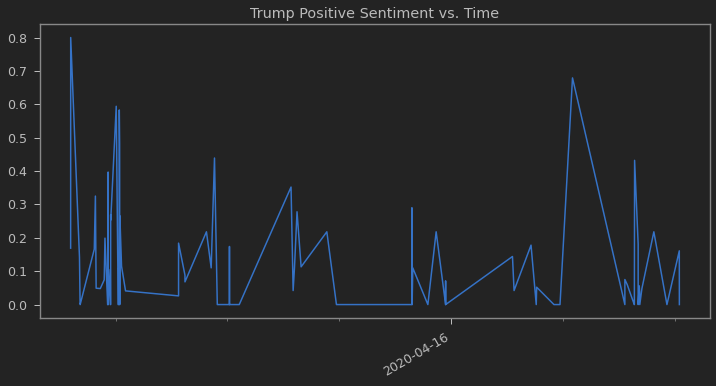

In [79]:
# trump tweets 
fig, ax = plt.subplots( figsize=(12,6))

ax.set_title('Trump Positive Sentiment vs. Time')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(trump_df['Created'], trump_df['pos'])

fig.autofmt_xdate()

plt.show()

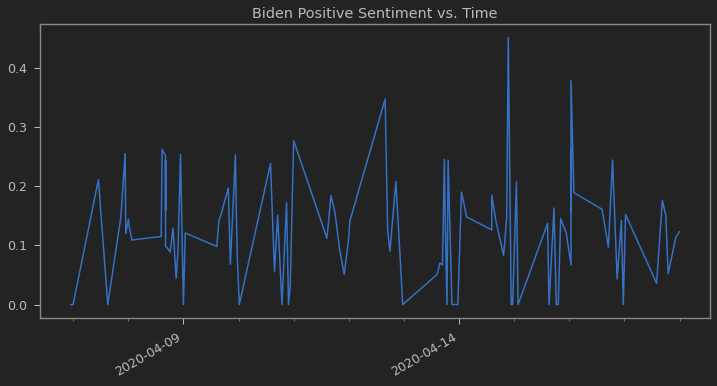

In [82]:
# biden tweets
fig, ax = plt.subplots( figsize=(12,6))

ax.set_title('Biden Positive Sentiment vs. Time')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(biden_df['Created'], biden_df['pos'])

fig.autofmt_xdate()

plt.show()

In [ ]:
# plotting positive and neg scores, whichever is greater
